In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [22]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [23]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2151.000000,2151.000000,2.151000e+03,2151.000000,2.151000e+03,2151.000000,2.151000e+03,2.151000e+03
mean,7536.957546,-0.990424,6.175903e-07,-0.000165,2.431095e-07,-0.000005,-2.994140e-07,7.474111e-08
std,4354.500254,0.001020,3.211219e-03,0.000703,2.138460e-03,0.006599,1.451511e-03,1.078893e-07
min,0.000000,-0.991665,-4.520937e-03,-0.001121,-3.245119e-03,-0.009033,-2.050332e-03,-1.181526e-07
25%,3768.478500,-0.991457,-3.216103e-03,-0.000860,-1.976982e-03,-0.006508,-1.466374e-03,-9.900478e-09
50%,7536.958000,-0.990588,1.015676e-05,-0.000215,2.367661e-06,-0.000377,-5.864952e-06,4.617278e-08
75%,11305.435000,-0.989402,3.221367e-03,0.000531,1.975589e-03,0.006449,1.464506e-03,1.594209e-07
max,15073.920000,-0.988842,4.520490e-03,0.000898,3.245231e-03,0.009929,2.048730e-03,3.558238e-07


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

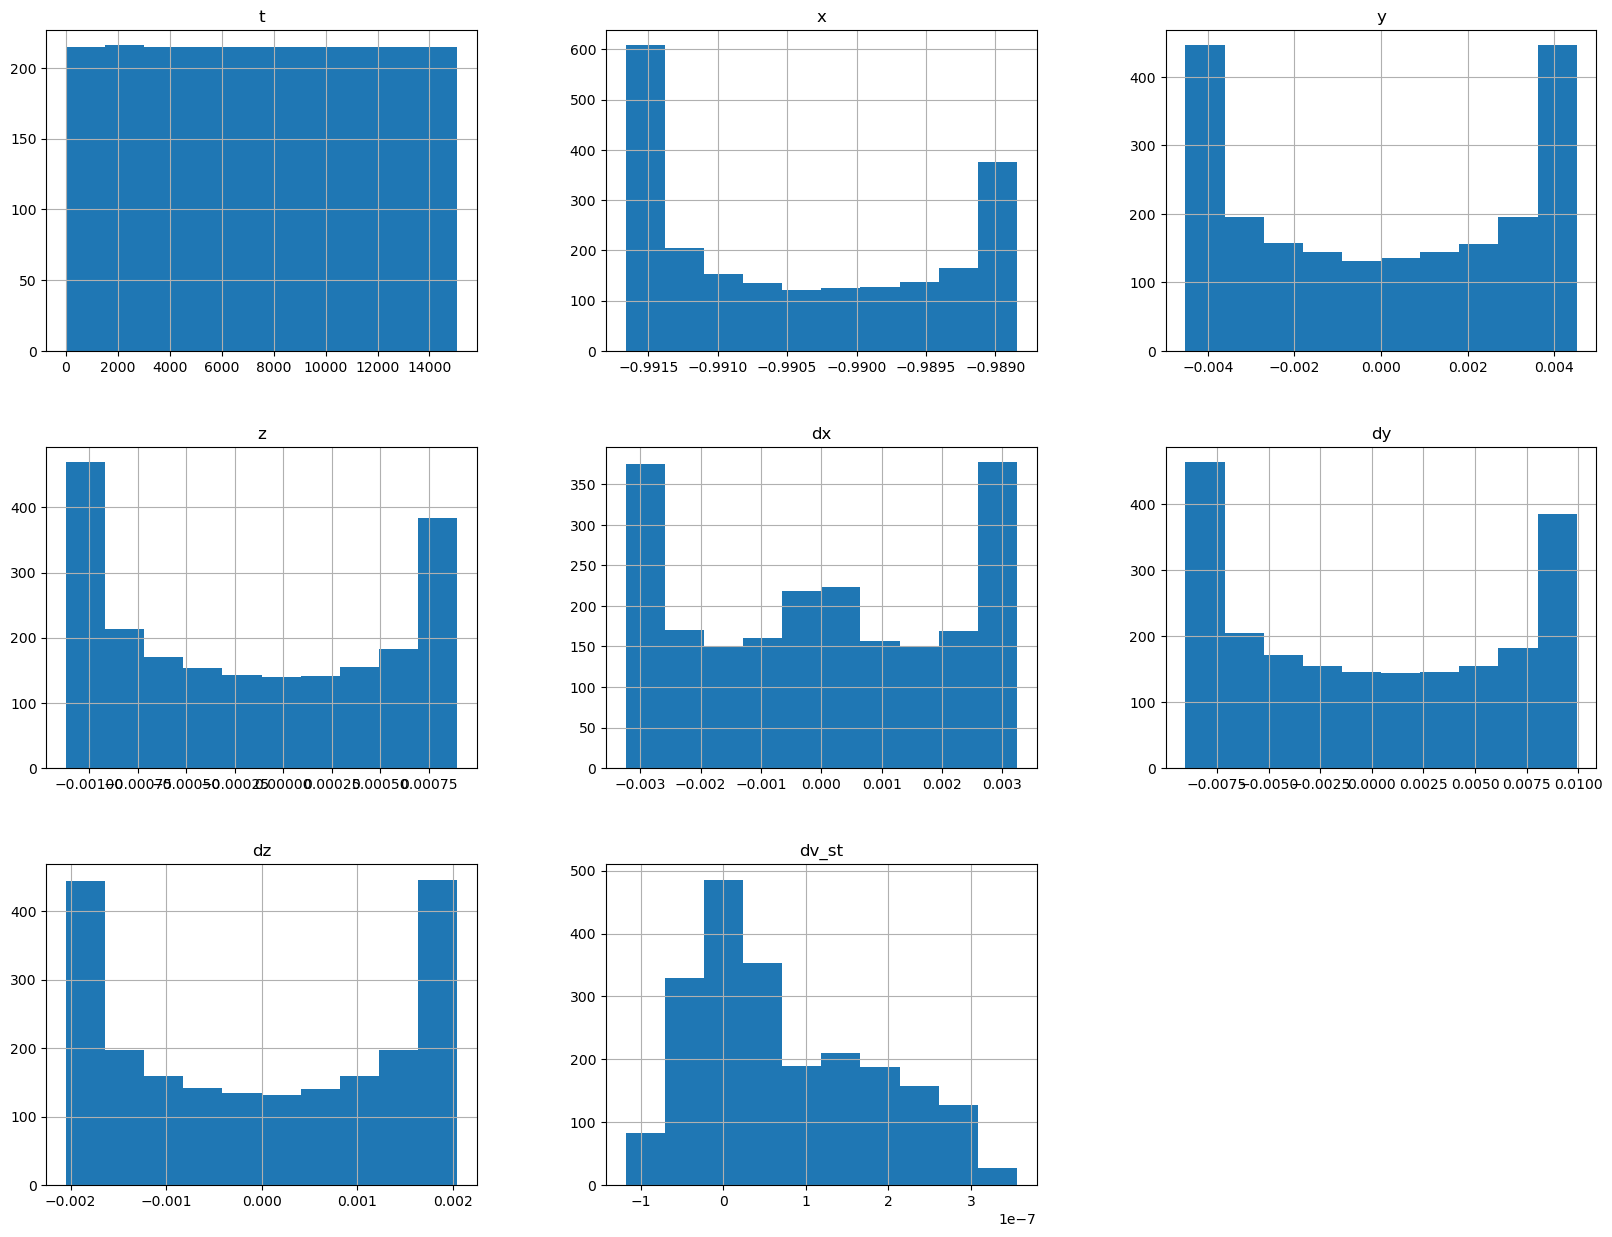

In [24]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Create a Train/Test Set

In [25]:
train_set, test_set = train_test_split(maneuvers, test_size=0.2, random_state=1)

## Visualizing Data

In [26]:
# Let's create a copy of the training set and call it 'maneuvers' again.
# This way we can play around with it without harming the training set.
maneuvers = train_set.copy()
maneuvers.size

13760

In [27]:
# Let's create a copy of the test set and call it 'maneuvers_test'.
# This way we can play around with it without harming the test set.
maneuvers_test = test_set.copy()
maneuvers_test.size

3448

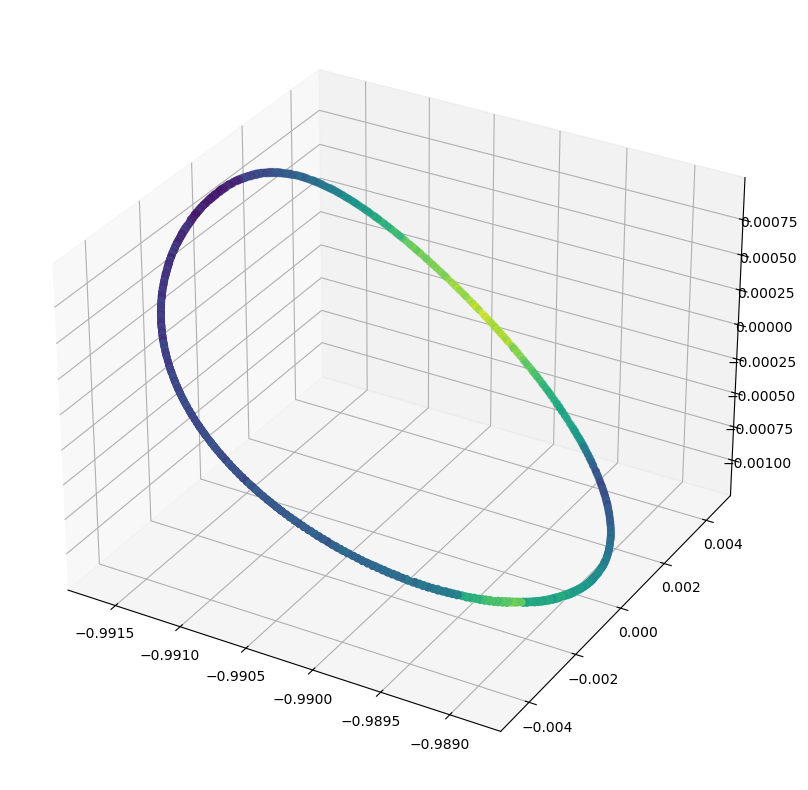

In [28]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [29]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
y        0.560778
dx       0.491772
x        0.411074
angle   -0.029675
dy      -0.472243
z       -0.474274
dz      -0.574085
Name: dv_st, dtype: float64

In [30]:
maneuvers_test["angle"]=maneuvers_test["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers_test = maneuvers_test.drop(["t"], axis=1)

array([[<Axes: xlabel='angle', ylabel='angle'>,
        <Axes: xlabel='x', ylabel='angle'>,
        <Axes: xlabel='dx', ylabel='angle'>,
        <Axes: xlabel='dv_st', ylabel='angle'>],
       [<Axes: xlabel='angle', ylabel='x'>,
        <Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='dx', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='angle', ylabel='dx'>,
        <Axes: xlabel='x', ylabel='dx'>,
        <Axes: xlabel='dx', ylabel='dx'>,
        <Axes: xlabel='dv_st', ylabel='dx'>],
       [<Axes: xlabel='angle', ylabel='dv_st'>,
        <Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='dx', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

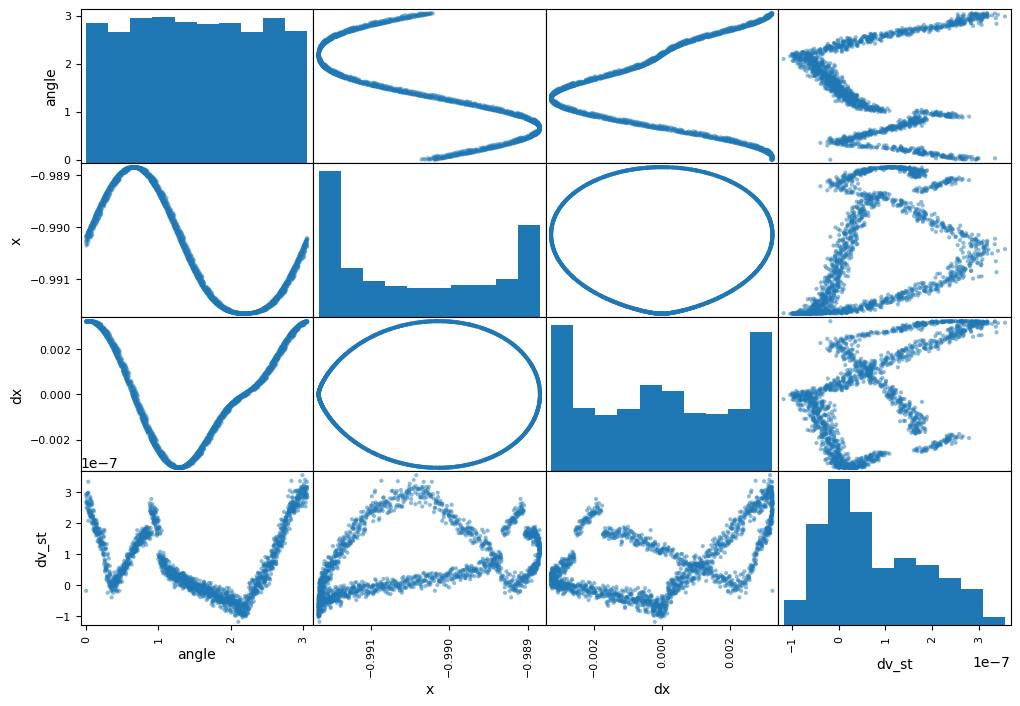

In [31]:
attributes = ["angle", "x", "dx", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

## Try Using Angle as the Single Descriptor

In [32]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers["angle"].copy()
maneuvers_predictors = maneuvers_predictors.array.reshape(-1,1)
maneuvers_labels = maneuvers["dv_st"].copy()
#print(maneuvers_predictors)

<NumpyExtensionArray>
[
[0.3169686434495427],
[2.5630809482794974],
[1.4267395477140834],
[2.655308563572469],
[2.6033667458478518],
[2.5726176206266196],
[0.2001507714835613],
[2.803756212949789],
[0.2500925892086805],
[1.3673804054505752],
[1.5221062711871243],
[0.42715025562827647],
[2.1910313789248135],
[2.8367246859808186],
[2.61632074273305],
[2.247992957020265],
[1.41420287536635],
[0.5617830163001072],
[2.6257183069016237],
[1.060867782157369],
[1.6853490488998668],
[2.6987334693208926],
[2.635115871068378],
[0.5925321415208846],
[1.387195294156832],
[1.6790708325406376],
[0.36267176555501646],
[0.9348523460243556],
[0.1387916292205551],
[1.3959904224919417],
[1.1543151578214466],
[2.5556833841113313],
[0.15472586573563962],
[0.30417351511316326],
[0.8956858962644834],
[0.41535512729164603],
[0.8670956395924776],
[1.7247739546474756],
[1.4022686388502614],
[2.4745117889742048],
[0.25537080556770597],
[2.918076933308341],
[0.7271649021927153],
[1.2412645567558473],
[0.4409453839

In [33]:
# Let's separate the predictors and the labels
maneuvers_test_predictors = maneuvers_test["angle"].copy()
maneuvers_test_predictors = maneuvers_test_predictors.array.reshape(-1,1)
maneuvers_test_labels = maneuvers_test["dv_st"].copy()

# Select and Train a Model

## Training and Evaluating on the Training Set

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(maneuvers_predictors, maneuvers_labels)

LinearRegression()

In [35]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(maneuvers_predictors)
lin_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.0710137649402769e-07

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [36]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(maneuvers_predictors, maneuvers_labels)

maneuvers_predictions = tree_reg.predict(maneuvers_predictors)
tree_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.2091262398344656e-08

NOW THIS IS MUCH BETTER!!

In [37]:
#Let's try it out on 5 instances from the test set
some_data = maneuvers_test_predictors[10:20]
some_labels = maneuvers_test_labels[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [3.064253401014493e-08, -5.2666109466666674e-09, 1.1924125714285714e-07, -5.503032642857143e-08, -5.92853445625e-09, 1.0002535340178574e-08, 1.193486e-07, 1.19240254e-07, 4.8293587999999997e-08, -5.92853445625e-09]
Labels: [1.713278e-08, -3.553479e-08, 1.516358e-07, -3.700378e-08, -1.395509e-08, 2.436123e-08, 6.034576e-08, 8.725498e-08, 3.193181e-08, 7.760322e-09]


In [38]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(maneuvers_predictors, maneuvers_labels)

maneuvers_predictions = forest_reg.predict(maneuvers_predictors)
forest_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.4564407436341373e-08

## Polynomial Regression

In [39]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(maneuvers_predictors)
#print(maneuvers_predictors.head())
#print(maneuvers_pred_poly[0])

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, maneuvers_labels)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

7.59886186477867e-08

## SVM Regression

In [41]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(maneuvers_predictors, maneuvers_labels)
maneuvers_predictions = svm_poly_reg.predict(maneuvers_predictors)
svm_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

1.1584455016765324e-07

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [42]:
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, maneuvers_predictors, maneuvers_labels,
scoring="neg_root_mean_squared_error", cv=5)
tree_rmse_scores = -scores

In [43]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [3.27281735e-08 2.91803553e-08 3.20117196e-08 2.49943599e-08
 3.02031064e-08]
Mean: 2.9823542961135435e-08
Standard deviation: 2.724105845701661e-09
